# Entropy vs Beta Analysis (Fixed)

Same Language for every vocabulary size experiments

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import RLM_files.datasets as datasets
import RLM_files.measures as measures

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Configuration

In [38]:
vocab_sizes = [32, 64, 128, 256]
beta_values = np.linspace(0.5, 5.0, 20)
L = 1

seed_rules = 12345678
seed_samples = 56781234
num_empirical_samples = 50000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Fixed Grammar Generation

Generate base grammar ONCE per vocabulary size, then scale by beta

In [39]:
def make_base_grammar(V, seed):
    """Generate base grammar structure (before beta scaling)."""
    torch.manual_seed(seed)
    S = torch.randn((V, V, V), device=device) * math.sqrt(math.log(V))
    return S

def apply_beta_to_grammar(S_base, beta):
    """Apply beta scaling and softmax to get grammar M."""
    S = S_base * beta
    return torch.softmax(S.view(S.shape[0], -1), dim=1).view(S.shape)

# Generate base grammars for each vocabulary size
base_grammars = {}
for V in vocab_sizes:
    base_grammars[V] = make_base_grammar(V, seed_rules)
    print(f"Generated base grammar for V={V}")

Generated base grammar for V=32
Generated base grammar for V=64
Generated base grammar for V=128
Generated base grammar for V=256


## Analytical Entropy

In [40]:
print("Computing analytical entropies...")
analytical_results = {}

for vocab_size in vocab_sizes:
    print(f"\nVocabulary size: {vocab_size}")
    conditional_entropies = []
    marginal_entropies = []
    
    S_base = base_grammars[vocab_size]
    
    for beta in tqdm(beta_values, desc=f"V={vocab_size}"):
        # Apply beta to the SAME base grammar
        M = apply_beta_to_grammar(S_base, beta)
        
        # Compute entropy
        cond_ent = measures.conditional_entropy(M, vocab_size, 0)
        marg_ent = measures.marginal(M, vocab_size, 0)
        
        conditional_entropies.append(cond_ent)
        marginal_entropies.append(marg_ent)
    
    analytical_results[vocab_size] = {
        'conditional': np.array(conditional_entropies),
        'marginal': np.array(marginal_entropies)
    }

print("\nAnalytical computation complete!")

Computing analytical entropies...

Vocabulary size: 32


V=32: 100%|██████████| 20/20 [00:00<00:00, 871.53it/s]



Vocabulary size: 64


V=64: 100%|██████████| 20/20 [00:00<00:00, 1350.06it/s]



Vocabulary size: 128


V=128: 100%|██████████| 20/20 [00:00<00:00, 68.99it/s]



Vocabulary size: 256


V=256: 100%|██████████| 20/20 [00:00<00:00, 27.27it/s]


Analytical computation complete!


## Empirical Entropy

In [ ]:
def compute_empirical_entropy_from_M(M, vocab_size, L, num_samples):
    """Compute empirical entropy given a grammar M."""
    # Create RLM with the given grammar
    rlm = datasets.RLM(
        v=vocab_size,
        L=L,
        beta=1.0,  #So it doesn't crash
        seed_rules=0,
        seed_samples=seed_samples,
        num_data=None,
        probs=None,
        transform=None,
        device=device
    )
    rlm.M = M  # Override with our grammar
    
    # Compute empirical statistics
    stats = rlm.compute_all_empirical_statistics(num_samples=num_samples)
    return stats['conditional_entropy'], stats['marginal_entropy']

print("Computing empirical entropies...")
empirical_results = {}

for vocab_size in vocab_sizes:
    print(f"\nVocabulary size: {vocab_size}")
    conditional_entropies = []
    marginal_entropies = []
    
    S_base = base_grammars[vocab_size]
    
    for beta in tqdm(beta_values, desc=f"V={vocab_size}"):
        # Apply beta to the SAME base grammar
        M = apply_beta_to_grammar(S_base, beta)
        
        # Compute empirical entropy
        cond_ent, marg_ent = compute_empirical_entropy_from_M(
            M, vocab_size, L, num_empirical_samples
        )
        
        conditional_entropies.append(cond_ent)
        marginal_entropies.append(marg_ent)
    
    empirical_results[vocab_size] = {
        'conditional': np.array(conditional_entropies),
        'marginal': np.array(marginal_entropies)
    }

print("\nEmpirical computation complete!")

Computing empirical entropies...

Vocabulary size: 32


V=32:   0%|          | 0/20 [00:00<?, ?it/s]


Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:   5%|▌         | 1/20 [00:04<01:21,  4.31s/it]

Empirical conditional entropy: 3.4359
Empirical marginal entropy: 3.4647

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:  10%|█         | 2/20 [00:08<01:15,  4.18s/it]

Empirical conditional entropy: 3.3867
Empirical marginal entropy: 3.4625

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:  15%|█▌        | 3/20 [00:12<01:10,  4.15s/it]

Empirical conditional entropy: 3.2658
Empirical marginal entropy: 3.4550

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:  20%|██        | 4/20 [00:16<01:05,  4.10s/it]

Empirical conditional entropy: 3.0703
Empirical marginal entropy: 3.4386

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:  25%|██▌       | 5/20 [00:20<01:01,  4.08s/it]

Empirical conditional entropy: 2.8233
Empirical marginal entropy: 3.4133

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:  30%|███       | 6/20 [00:24<00:56,  4.05s/it]

Empirical conditional entropy: 2.5603
Empirical marginal entropy: 3.3812

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:  35%|███▌      | 7/20 [00:28<00:52,  4.01s/it]

Empirical conditional entropy: 2.3036
Empirical marginal entropy: 3.3471

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:  40%|████      | 8/20 [00:32<00:48,  4.02s/it]

Empirical conditional entropy: 2.0867
Empirical marginal entropy: 3.3160

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:  45%|████▌     | 9/20 [00:36<00:44,  4.02s/it]

Empirical conditional entropy: 1.8855
Empirical marginal entropy: 3.2818

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:  50%|█████     | 10/20 [00:40<00:40,  4.04s/it]

Empirical conditional entropy: 1.7170
Empirical marginal entropy: 3.2516

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:  55%|█████▌    | 11/20 [00:44<00:36,  4.00s/it]

Empirical conditional entropy: 1.5804
Empirical marginal entropy: 3.2251

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:  60%|██████    | 12/20 [00:48<00:32,  4.01s/it]

Empirical conditional entropy: 1.4616
Empirical marginal entropy: 3.1988

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:  65%|██████▌   | 13/20 [00:52<00:28,  4.04s/it]

Empirical conditional entropy: 1.3612
Empirical marginal entropy: 3.1755

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:  70%|███████   | 14/20 [00:56<00:23,  4.00s/it]

Empirical conditional entropy: 1.2727
Empirical marginal entropy: 3.1534

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:  75%|███████▌  | 15/20 [01:00<00:19,  3.97s/it]

Empirical conditional entropy: 1.1927
Empirical marginal entropy: 3.1313

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:  80%|████████  | 16/20 [01:04<00:15,  3.96s/it]

Empirical conditional entropy: 1.1271
Empirical marginal entropy: 3.1116

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:  85%|████████▌ | 17/20 [01:08<00:11,  3.99s/it]

Empirical conditional entropy: 1.0684
Empirical marginal entropy: 3.0936

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:  90%|█████████ | 18/20 [01:12<00:08,  4.01s/it]

Empirical conditional entropy: 1.0168
Empirical marginal entropy: 3.0759

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32:  95%|█████████▌| 19/20 [01:16<00:03,  3.99s/it]

Empirical conditional entropy: 0.9723
Empirical marginal entropy: 3.0579

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=32: 100%|██████████| 20/20 [01:20<00:00,  4.02s/it]


Empirical conditional entropy: 0.9303
Empirical marginal entropy: 3.0418

Vocabulary size: 64


V=64:   0%|          | 0/20 [00:00<?, ?it/s]


Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:   5%|▌         | 1/20 [00:16<05:08, 16.24s/it]

Empirical conditional entropy: 4.1031
Empirical marginal entropy: 4.1581

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:  10%|█         | 2/20 [00:32<04:53, 16.31s/it]

Empirical conditional entropy: 4.0618
Empirical marginal entropy: 4.1572

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:  15%|█▌        | 3/20 [00:48<04:35, 16.19s/it]

Empirical conditional entropy: 3.9393
Empirical marginal entropy: 4.1536

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:  20%|██        | 4/20 [01:05<04:20, 16.26s/it]

Empirical conditional entropy: 3.7000
Empirical marginal entropy: 4.1438

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:  25%|██▌       | 5/20 [01:21<04:05, 16.34s/it]

Empirical conditional entropy: 3.3652
Empirical marginal entropy: 4.1268

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:  30%|███       | 6/20 [01:37<03:48, 16.33s/it]

Empirical conditional entropy: 2.9896
Empirical marginal entropy: 4.1054

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:  35%|███▌      | 7/20 [01:54<03:32, 16.36s/it]

Empirical conditional entropy: 2.6475
Empirical marginal entropy: 4.0825

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:  40%|████      | 8/20 [02:10<03:15, 16.31s/it]

Empirical conditional entropy: 2.3495
Empirical marginal entropy: 4.0615

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:  45%|████▌     | 9/20 [02:26<02:58, 16.27s/it]

Empirical conditional entropy: 2.0963
Empirical marginal entropy: 4.0407

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:  50%|█████     | 10/20 [02:42<02:42, 16.28s/it]

Empirical conditional entropy: 1.8946
Empirical marginal entropy: 4.0231

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:  55%|█████▌    | 11/20 [02:59<02:26, 16.24s/it]

Empirical conditional entropy: 1.7196
Empirical marginal entropy: 4.0065

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:  60%|██████    | 12/20 [03:14<02:09, 16.14s/it]

Empirical conditional entropy: 1.5891
Empirical marginal entropy: 3.9930

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:  65%|██████▌   | 13/20 [03:30<01:52, 16.11s/it]

Empirical conditional entropy: 1.4711
Empirical marginal entropy: 3.9817

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:  70%|███████   | 14/20 [03:47<01:36, 16.16s/it]

Empirical conditional entropy: 1.3768
Empirical marginal entropy: 3.9709

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:  75%|███████▌  | 15/20 [04:03<01:21, 16.23s/it]

Empirical conditional entropy: 1.3015
Empirical marginal entropy: 3.9601

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:  80%|████████  | 16/20 [04:20<01:05, 16.27s/it]

Empirical conditional entropy: 1.2350
Empirical marginal entropy: 3.9513

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:  85%|████████▌ | 17/20 [04:36<00:49, 16.36s/it]

Empirical conditional entropy: 1.1813
Empirical marginal entropy: 3.9442

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:  90%|█████████ | 18/20 [04:52<00:32, 16.23s/it]

Empirical conditional entropy: 1.1335
Empirical marginal entropy: 3.9358

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64:  95%|█████████▌| 19/20 [05:08<00:16, 16.30s/it]

Empirical conditional entropy: 1.0927
Empirical marginal entropy: 3.9296

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=64: 100%|██████████| 20/20 [05:25<00:00, 16.27s/it]


Empirical conditional entropy: 1.0555
Empirical marginal entropy: 3.9222

Vocabulary size: 128


V=128:   0%|          | 0/20 [00:00<?, ?it/s]


Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:   5%|▌         | 1/20 [00:43<13:53, 43.85s/it]

Empirical conditional entropy: 4.6694
Empirical marginal entropy: 4.8505

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:  10%|█         | 2/20 [01:25<12:42, 42.34s/it]

Empirical conditional entropy: 4.6333
Empirical marginal entropy: 4.8503

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:  15%|█▌        | 3/20 [02:07<12:00, 42.39s/it]

Empirical conditional entropy: 4.5178
Empirical marginal entropy: 4.8486

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:  20%|██        | 4/20 [02:46<10:57, 41.06s/it]

Empirical conditional entropy: 4.2448
Empirical marginal entropy: 4.8423

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:  25%|██▌       | 5/20 [03:25<10:06, 40.46s/it]

Empirical conditional entropy: 3.8082
Empirical marginal entropy: 4.8270

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:  30%|███       | 6/20 [04:06<09:25, 40.43s/it]

Empirical conditional entropy: 3.3242
Empirical marginal entropy: 4.8049

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:  35%|███▌      | 7/20 [04:47<08:49, 40.69s/it]

Empirical conditional entropy: 2.8623
Empirical marginal entropy: 4.7776

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:  40%|████      | 8/20 [05:30<08:17, 41.48s/it]

Empirical conditional entropy: 2.4715
Empirical marginal entropy: 4.7468

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:  45%|████▌     | 9/20 [06:13<07:39, 41.79s/it]

Empirical conditional entropy: 2.1527
Empirical marginal entropy: 4.7176

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:  50%|█████     | 10/20 [06:55<07:00, 42.05s/it]

Empirical conditional entropy: 1.9062
Empirical marginal entropy: 4.6902

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:  55%|█████▌    | 11/20 [07:38<06:19, 42.16s/it]

Empirical conditional entropy: 1.7183
Empirical marginal entropy: 4.6683

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:  60%|██████    | 12/20 [08:18<05:32, 41.61s/it]

Empirical conditional entropy: 1.5698
Empirical marginal entropy: 4.6473

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:  65%|██████▌   | 13/20 [08:58<04:47, 41.11s/it]

Empirical conditional entropy: 1.4476
Empirical marginal entropy: 4.6280

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:  70%|███████   | 14/20 [09:39<04:06, 41.11s/it]

Empirical conditional entropy: 1.3479
Empirical marginal entropy: 4.6103

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:  75%|███████▌  | 15/20 [10:21<03:26, 41.23s/it]

Empirical conditional entropy: 1.2681
Empirical marginal entropy: 4.5950

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:  80%|████████  | 16/20 [11:05<02:48, 42.00s/it]

Empirical conditional entropy: 1.1967
Empirical marginal entropy: 4.5819

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:  85%|████████▌ | 17/20 [11:44<02:03, 41.32s/it]

Empirical conditional entropy: 1.1347
Empirical marginal entropy: 4.5690

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:  90%|█████████ | 18/20 [12:27<01:23, 41.84s/it]

Empirical conditional entropy: 1.0838
Empirical marginal entropy: 4.5565

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128:  95%|█████████▌| 19/20 [13:11<00:42, 42.52s/it]

Empirical conditional entropy: 1.0398
Empirical marginal entropy: 4.5452

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=128: 100%|██████████| 20/20 [13:51<00:00, 41.58s/it]


Empirical conditional entropy: 1.0064
Empirical marginal entropy: 4.5360

Vocabulary size: 256


V=256:   0%|          | 0/20 [00:00<?, ?it/s]


Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:   5%|▌         | 1/20 [02:20<44:28, 140.45s/it]

Empirical conditional entropy: 4.8186
Empirical marginal entropy: 5.5430

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:  10%|█         | 2/20 [04:45<42:57, 143.19s/it]

Empirical conditional entropy: 4.7999
Empirical marginal entropy: 5.5431

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:  15%|█▌        | 3/20 [07:04<40:01, 141.28s/it]

Empirical conditional entropy: 4.7009
Empirical marginal entropy: 5.5415

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:  20%|██        | 4/20 [09:22<37:20, 140.02s/it]

Empirical conditional entropy: 4.4419
Empirical marginal entropy: 5.5362

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:  25%|██▌       | 5/20 [11:41<34:55, 139.72s/it]

Empirical conditional entropy: 3.9832
Empirical marginal entropy: 5.5215

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:  30%|███       | 6/20 [14:02<32:40, 140.01s/it]

Empirical conditional entropy: 3.4660
Empirical marginal entropy: 5.4987

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:  35%|███▌      | 7/20 [16:25<30:33, 141.05s/it]

Empirical conditional entropy: 2.9971
Empirical marginal entropy: 5.4719

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:  40%|████      | 8/20 [18:50<28:26, 142.19s/it]

Empirical conditional entropy: 2.5922
Empirical marginal entropy: 5.4437

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:  45%|████▌     | 9/20 [21:15<26:14, 143.17s/it]

Empirical conditional entropy: 2.2780
Empirical marginal entropy: 5.4153

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:  50%|█████     | 10/20 [23:33<23:36, 141.64s/it]

Empirical conditional entropy: 2.0240
Empirical marginal entropy: 5.3891

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:  55%|█████▌    | 11/20 [25:50<21:00, 140.10s/it]

Empirical conditional entropy: 1.8267
Empirical marginal entropy: 5.3664

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:  60%|██████    | 12/20 [28:07<18:32, 139.10s/it]

Empirical conditional entropy: 1.6721
Empirical marginal entropy: 5.3457

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:  65%|██████▌   | 13/20 [30:24<16:09, 138.47s/it]

Empirical conditional entropy: 1.5441
Empirical marginal entropy: 5.3268

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:  70%|███████   | 14/20 [32:43<13:52, 138.68s/it]

Empirical conditional entropy: 1.4411
Empirical marginal entropy: 5.3091

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:  75%|███████▌  | 15/20 [35:01<11:32, 138.53s/it]

Empirical conditional entropy: 1.3488
Empirical marginal entropy: 5.2915

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:  80%|████████  | 16/20 [37:18<09:11, 137.93s/it]

Empirical conditional entropy: 1.2724
Empirical marginal entropy: 5.2769

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:  85%|████████▌ | 17/20 [39:37<06:55, 138.43s/it]

Empirical conditional entropy: 1.2077
Empirical marginal entropy: 5.2623

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:  90%|█████████ | 18/20 [41:57<04:37, 138.78s/it]

Empirical conditional entropy: 1.1523
Empirical marginal entropy: 5.2493

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256:  95%|█████████▌| 19/20 [44:17<02:19, 139.27s/it]

Empirical conditional entropy: 1.1044
Empirical marginal entropy: 5.2371

Computing empirical statistics from 50000 samples...
Computing empirical bigram distribution from 50000 samples...


V=256: 100%|██████████| 20/20 [46:35<00:00, 139.78s/it]

Empirical conditional entropy: 1.0649
Empirical marginal entropy: 5.2259

Empirical computation complete!


## Visualization: Conditional Entropy vs Beta

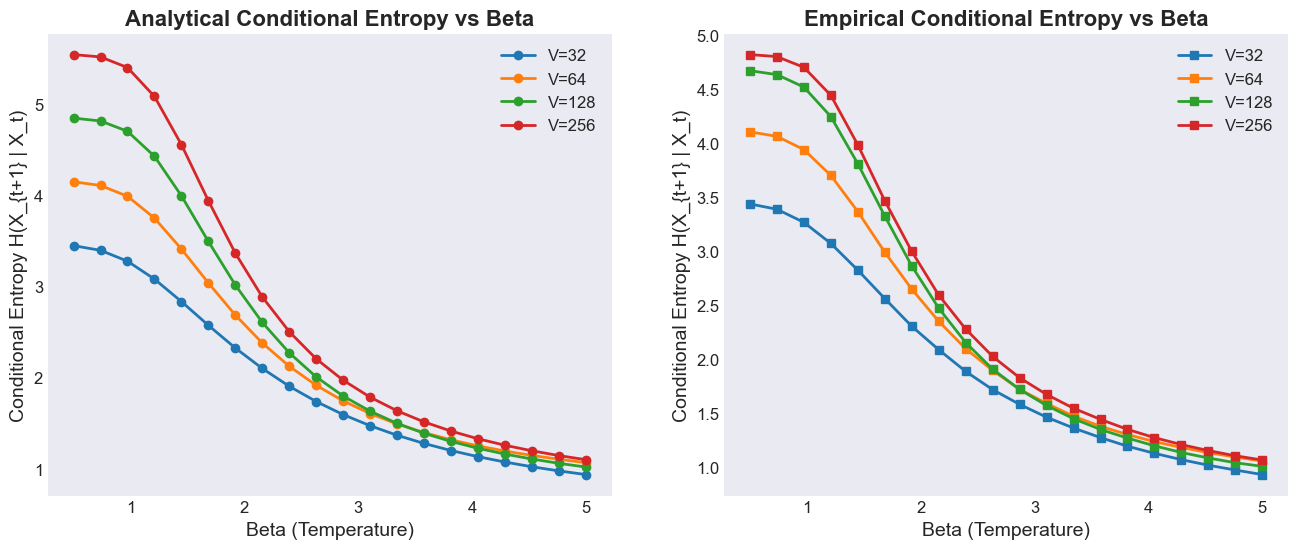

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Analytical
for vocab_size in vocab_sizes:
    ax1.plot(
        beta_values,
        analytical_results[vocab_size]['conditional'],
        marker='o',
        label=f'V={vocab_size}',
        linewidth=2,
        markersize=6
    )

ax1.set_xlabel('Beta (Temperature)', fontsize=14)
ax1.set_ylabel('Conditional Entropy H(X_{t+1} | X_t)', fontsize=14)
ax1.set_title('Analytical Conditional Entropy vs Beta', fontsize=16, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(False)

# Empirical
for vocab_size in vocab_sizes:
    ax2.plot(
        beta_values,
        empirical_results[vocab_size]['conditional'],
        marker='s',
        label=f'V={vocab_size}',
        linewidth=2,
        markersize=6
    )

ax2.set_xlabel('Beta (Temperature)', fontsize=14)
ax2.set_ylabel('Conditional Entropy H(X_{t+1} | X_t)', fontsize=14)
ax2.set_title('Empirical Conditional Entropy vs Beta', fontsize=16, fontweight='bold')
ax2.legend(fontsize=12)
ax2.grid(False)



## Comparison: Analytical vs Empirical

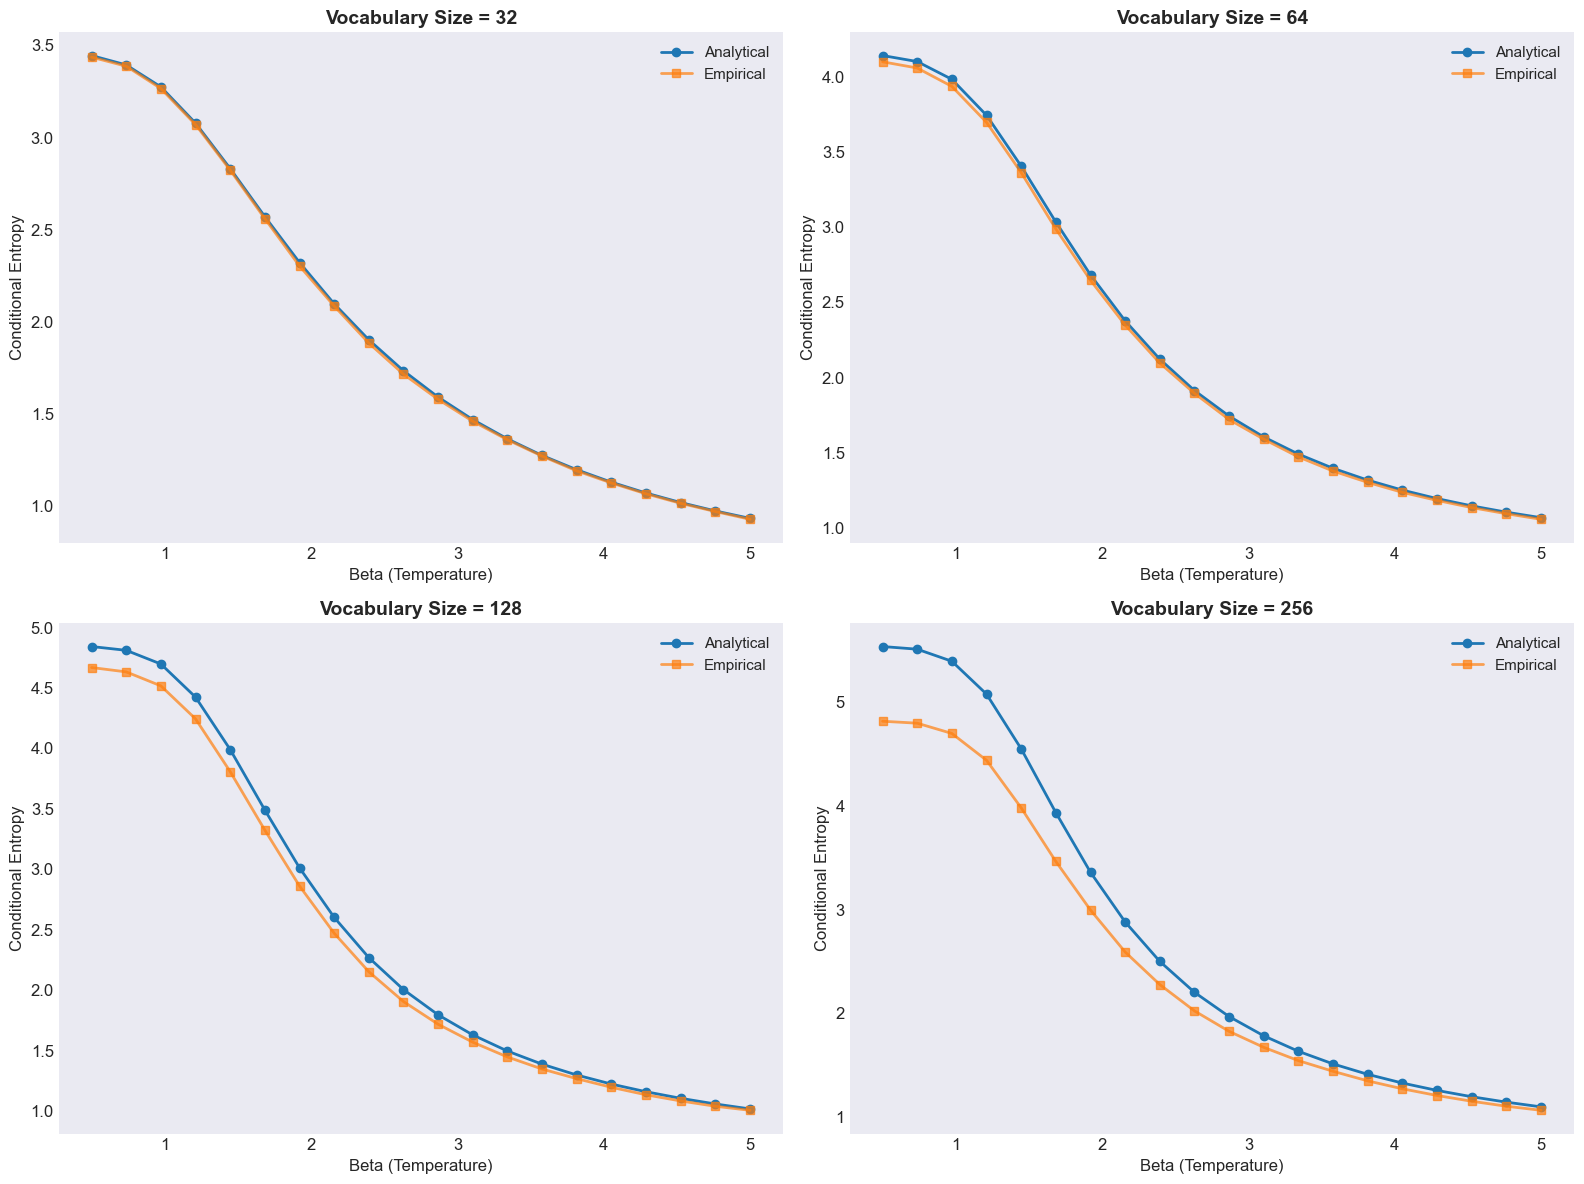

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, vocab_size in enumerate(vocab_sizes):
    ax = axes[idx]
    
    ax.plot(
        beta_values,
        analytical_results[vocab_size]['conditional'],
        marker='o',
        label='Analytical',
        linewidth=2,
        markersize=6
    )
    ax.plot(
        beta_values,
        empirical_results[vocab_size]['conditional'],
        marker='s',
        label='Empirical',
        linewidth=2,
        markersize=6,
        alpha=0.7
    )
    
    ax.set_xlabel('Beta (Temperature)', fontsize=12)
    ax.set_ylabel('Conditional Entropy', fontsize=12)
    ax.set_title(f'Vocabulary Size = {vocab_size}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(False)
    

plt.tight_layout()
plt.show()

## Summary Statistics

In [43]:
print("\n" + "="*80)
print("SUMMARY: Conditional Entropy vs Beta")
print("="*80)

for vocab_size in vocab_sizes:
    print(f"\nVocabulary Size: {vocab_size}")
    print("-" * 40)
    
    anal_cond = analytical_results[vocab_size]['conditional']
    print(f"Analytical Conditional Entropy:")
    print(f"  At β=0.5: {anal_cond[0]:.4f}")
    print(f"  At β=5.0: {anal_cond[-1]:.4f}")
    print(f"  Monotonic decreasing: {np.all(np.diff(anal_cond) <= 0)}")
    
    emp_cond = empirical_results[vocab_size]['conditional']
    print(f"\nEmpirical Conditional Entropy:")
    print(f"  At β=0.5: {emp_cond[0]:.4f}")
    print(f"  At β=5.0: {emp_cond[-1]:.4f}")
    
    diff = np.abs(anal_cond - emp_cond)
    print(f"\nAnalytical vs Empirical:")
    print(f"  Mean absolute difference: {diff.mean():.4f}")
    print(f"  Max absolute difference: {diff.max():.4f}")
    
    print(f"\nTheoretical Maximum (log V): {np.log(vocab_size):.4f}")


SUMMARY: Conditional Entropy vs Beta

Vocabulary Size: 32
----------------------------------------
Analytical Conditional Entropy:
  At β=0.5: 3.4447
  At β=5.0: 0.9353
  Monotonic decreasing: True

Empirical Conditional Entropy:
  At β=0.5: 3.4359
  At β=5.0: 0.9303

Analytical vs Empirical:
  Mean absolute difference: 0.0088
  Max absolute difference: 0.0189

Theoretical Maximum (log V): 3.4657

Vocabulary Size: 64
----------------------------------------
Analytical Conditional Entropy:
  At β=0.5: 4.1449
  At β=5.0: 1.0662
  Monotonic decreasing: True

Empirical Conditional Entropy:
  At β=0.5: 4.1031
  At β=5.0: 1.0555

Analytical vs Empirical:
  Mean absolute difference: 0.0263
  Max absolute difference: 0.0472

Theoretical Maximum (log V): 4.1589

Vocabulary Size: 128
----------------------------------------
Analytical Conditional Entropy:
  At β=0.5: 4.8431
  At β=5.0: 1.0179
  Monotonic decreasing: True

Empirical Conditional Entropy:
  At β=0.5: 4.6694
  At β=5.0: 1.0064

Ana

# Pure analytical 

In [44]:
vocab_sizes = [32, 64, 128, 256]
beta_values = np.linspace(0.5, 3.5, 200)
L = 1

seed_rules = 12345678
seed_samples = 56781234

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [45]:
def make_base_grammar(V, seed):
    """Generate base grammar structure (before beta scaling)."""
    torch.manual_seed(seed)
    S = torch.randn((V, V, V), device=device) * math.sqrt(math.log(V))
    return S

def apply_beta_to_grammar(S_base, beta):
    """Apply beta scaling and softmax to get grammar M."""
    S = S_base * beta
    return torch.softmax(S.view(S.shape[0], -1), dim=1).view(S.shape)

# Generate base grammars for each vocabulary size
base_grammars = {}
for V in vocab_sizes:
    base_grammars[V] = make_base_grammar(V, seed_rules)
    print(f"Generated base grammar for V={V}")

Generated base grammar for V=32
Generated base grammar for V=64
Generated base grammar for V=128
Generated base grammar for V=256


In [46]:
print("Computing analytical entropies...")
analytical_results = {}

for vocab_size in vocab_sizes:
    print(f"\nVocabulary size: {vocab_size}")
    conditional_entropies = []
    marginal_entropies = []
    
    S_base = base_grammars[vocab_size]
    
    for beta in tqdm(beta_values, desc=f"V={vocab_size}"):
        # Apply beta to the SAME base grammar
        M = apply_beta_to_grammar(S_base, beta)
        
        # Compute entropy
        cond_ent = measures.conditional_entropy(M, vocab_size, 0)
        marg_ent = measures.marginal(M, vocab_size, 0)
        
        conditional_entropies.append(cond_ent)
        marginal_entropies.append(marg_ent)
    
    analytical_results[vocab_size] = {
        'conditional': np.array(conditional_entropies),
        'marginal': np.array(marginal_entropies)
    }

print("\nAnalytical computation complete!")

Computing analytical entropies...

Vocabulary size: 32


V=32: 100%|██████████| 200/200 [00:00<00:00, 2912.98it/s]



Vocabulary size: 64


V=64: 100%|██████████| 200/200 [00:00<00:00, 1716.63it/s]



Vocabulary size: 128


V=128: 100%|██████████| 200/200 [00:02<00:00, 89.69it/s] 



Vocabulary size: 256


V=256: 100%|██████████| 200/200 [00:06<00:00, 31.19it/s]


Analytical computation complete!


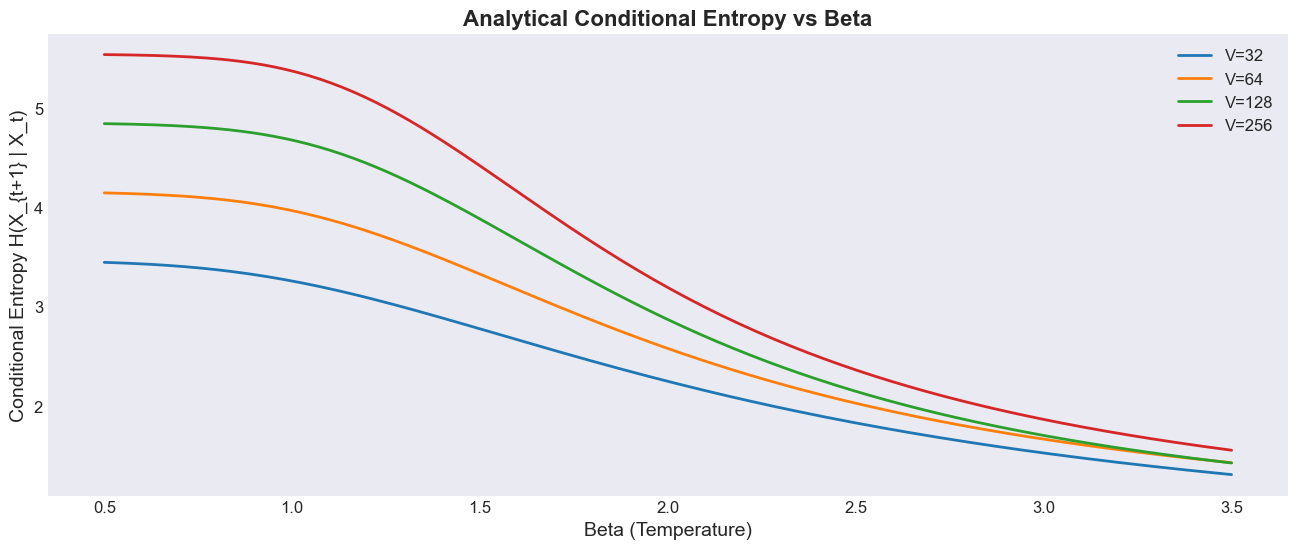

In [47]:
fig, (ax1) = plt.subplots(1, figsize=(16, 6))
# Analytical
for vocab_size in vocab_sizes:
    ax1.plot(
        beta_values,
        analytical_results[vocab_size]['conditional'],
        label=f'V={vocab_size}',
        linewidth=2,
        markersize=6
    )

ax1.set_xlabel('Beta (Temperature)', fontsize=14)
ax1.set_ylabel('Conditional Entropy H(X_{t+1} | X_t)', fontsize=14)
ax1.set_title('Analytical Conditional Entropy vs Beta', fontsize=16, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(False)